In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from sklearn.metrics import f1_score
import torch.nn.functional as F




In [3]:
# Klasörlerin tanımlanması
data_path = Path('Data') # Veri klasörünün yolu
folders = ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor'] # Her sınıfın klasör isimleri
img_size = (128, 128)  # Görüntülerin boyutlandırılacağı hedef boyut

# data ve etiket listeleri
data = [] # Görüntüleri saklamak için liste
labels = [] # Etiketleri saklamak için liste

# Her klasörde dolaşma
for folder_idx, folder in enumerate(folders):
    folder_path = data_path / folder # Klasör yolunu oluşturma
    
    # Klasördeki tüm fotoğrafları al
    for filename in tqdm(os.listdir(folder_path), desc=f"Processing {folder}"):
        file_path = folder_path / filename
        
        # Fotoğrafı yükleme
        img = cv2.imread(str(file_path))
        
        # Dosyanın başarılı bir şekilde yüklenip yüklenmediğini kontrol etme
        if img is None:
            print(f"Warning: {file_path} could not be loaded.")
            continue
        
        # Boyutlandırma ve renk kanallarını düzeltme
        img = cv2.resize(img, img_size) # Görüntüyü yeniden boyutlandırma
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Renk kanallarını RGB'ye dönüştürme
        
        
        # Veri listesine ekleme
        data.append(img)
        
        # Etiket listesine ekleme
        labels.append(folder_idx) # Sınıf etiketini ekleme

# Veri ve etiket listelerini numpy dizilerine dönüştürme
data = np.array(data)
labels = np.array(labels)

# Veri ve etiketlerin şeklini kontrol etme
print("Veri şekli:", data.shape)
print("Etiket şekli:", labels.shape)




Processing pituitary_tumor: 100%|██████████| 844/844 [00:01<00:00, 530.63it/s]

Veri şekli: (3096, 128, 128, 3)
Etiket şekli: (3096,)


c:\Users\snbyr\anaconda3\envs\eb\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\snbyr\anaconda3\envs\eb\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Train Loss: 0.5225, Test Loss: 0.5103, Train Accuracy: 0.8086, Test Accuracy: 0.8226
Epoch 2/20, Train Loss: 0.2735, Test Loss: 0.4766, Train Accuracy: 0.9015, Test Accuracy: 0.8387
Epoch 3/20, Train Loss: 0.2107, Test Loss: 0.5459, Train Accuracy: 0.9285, Test Accuracy: 0.8016
Epoch 4/20, Train Loss: 0.1401, Test Loss: 0.1925, Train Accuracy: 0.9544, Test Accuracy: 0.9290
Epoch 5/20, Train Loss: 0.1395, Test Loss: 3.6077, Train Accuracy: 0.9532, Test Accuracy: 0.3484
Epoch 6/20, Train Loss: 0.1337, Test Loss: 0.9198, Train Accuracy: 0.9532, Test Accuracy: 0.7403
Epoch 7/20, Train Loss: 0.0964, Test Loss: 0.3987, Train Accuracy: 0.9657, Test Accuracy: 0.8871
Epoch 8/20, Train Loss: 0.0657, Test Loss: 0.6952, Train Accuracy: 0.9754, Test Accuracy: 0.8048
Epoch 9/20, Train Loss: 0.0445, Test Loss: 0.3332, Train Accuracy: 0.9863, Test Accuracy: 0.9032
Epoch 10/20, Train Loss: 0.0286, Test Loss: 0.4600, Train Accuracy: 0.9923, Test Accuracy: 0.8613
Epoch 11/20, Train Loss: 0.07

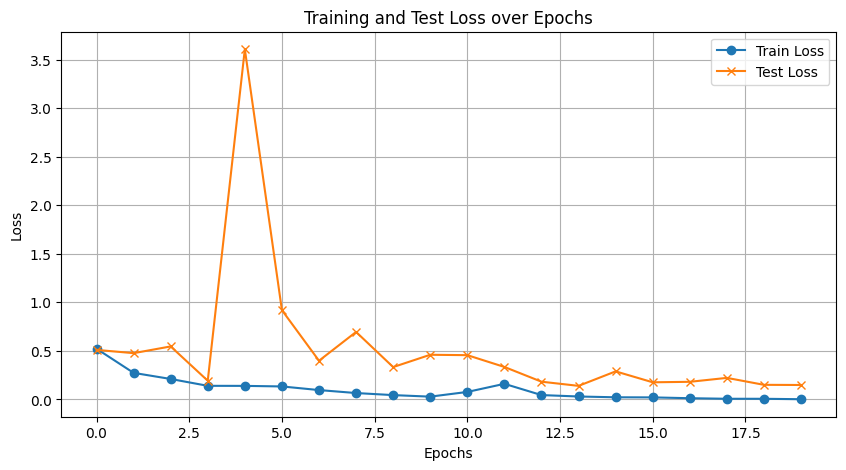

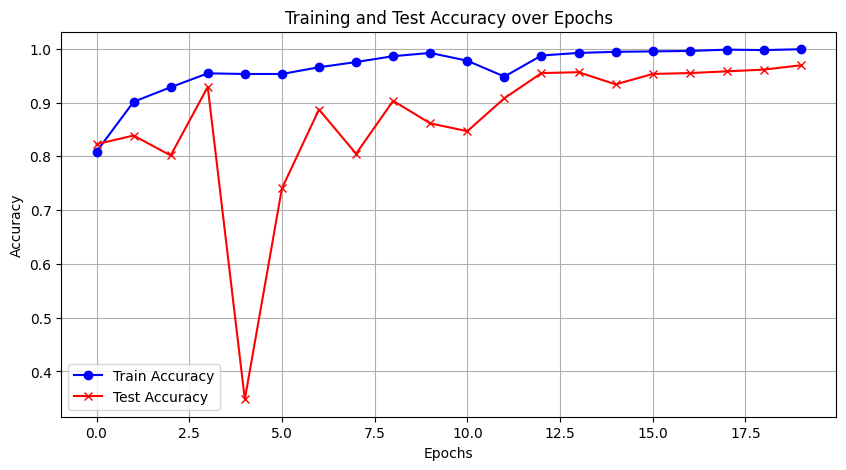

Final Test Loss: 0.1487, Final Test Accuracy: 0.9694
Final Train Accuracy: 0.9992


In [4]:
# Veriyi train ve test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)

# Verileri normalize etme
X_train = X_train / 255.0
X_test = X_test / 255.0

# Verileri tensor formatına dönüştürme
X_train = torch.tensor(X_train.transpose((0, 3, 1, 2))).float()
X_test = torch.tensor(X_test.transpose((0, 3, 1, 2))).float()
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Train ve test veri setleri oluşturma
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

# Transformlar
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # ResNet için 224x224 boyutuna getiriyoruz
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Dataset ve DataLoader oluşturma
train_dataset = ImageDataset(X_train, y_train, transform=train_transforms)
test_dataset = ImageDataset(X_test, y_test, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model tanımlama ve yüklenmesi (ResNet18 kullanıyoruz)
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)  # 4 classes

# Optimizer ve loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# DataLoader üzerinden veri dolaşma ve model eğitimi
num_epochs = 20
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        
        _, predicted_train = torch.max(outputs, 1)
        correct_train += (predicted_train == labels).sum().item()
        total_train += labels.size(0)
    
    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    # Test seti üzerinde modelin performansını test etme
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels) 
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(test_loss)
    
    # Accuracy hesaplama
    test_accuracy = correct / total
    test_accuracies.append(test_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, "
          f"Test Accuracy: {test_accuracy:.4f}")

# Training loss grafiği
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(test_losses, label='Test Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy grafiği
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy', marker='o', color='b')
plt.plot(test_accuracies, label='Test Accuracy', marker='x', color='r')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Son modeli kaydetme
torch.save(model.state_dict(), 'resnet_model.pth')

# Son durumdaki loss ve accuracy değerleri
print(f"Final Test Loss: {test_losses[-1]:.4f}, Final Test Accuracy: {test_accuracies[-1]:.4f}")
print(f"Final Train Accuracy: {train_accuracies[-1]:.4f}")

In [20]:
# Veriyi train ve test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels # Stratify ile dengeli dağılım
)

# Verileri normalize etme
X_train = X_train / 255.0 # 0-255 aralığından 0-1 aralığına getirme
X_test = X_test / 255.0

# Verileri tensor formatına dönüştürme
X_train = torch.tensor(X_train.transpose((0, 3, 1, 2))).float() # Channel dimensiona geçiş
X_test = torch.tensor(X_test.transpose((0, 3, 1, 2))).float()
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Train ve test veri setleri oluşturma
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images # Görüntüleri saklama
        self.labels = labels # Etiketleri saklama
        self.transform = transform # Transformları saklama
        
    def __len__(self):
        return len(self.images) # Veri setinin uzunluğunu döndürme
    
    def __getitem__(self, idx):
        img = self.images[idx]# İlgili index'teki görüntüyü alma
        label = self.labels[idx]# İlgili index'teki etiketi alma
        
        if self.transform:
            img = self.transform(img)# Transform varsa uygulama
        
        
        return img, label

# Transformlar
train_transforms = transforms.Compose([
    transforms.ToPILImage(), # Görüntüyü PIL formatına dönüştürme
    transforms.Resize((224, 224)),  # ResNet için 224x224 boyutuna getiriyoruz
    transforms.RandomHorizontalFlip(),# Yatayda rastgele çevirme
    transforms.RandomRotation(10),# Rastgele 10 derece döndürme
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),# Rastgele kırpma
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),# Renk değişiklikleri
    transforms.ToTensor(),# Görüntüyü tensor formatına dönüştürme
])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),# Görüntüyü PIL formatına dönüştürme
    transforms.Resize((224, 224)),# ResNet için 224x224 boyutuna getirme
    transforms.ToTensor(),# Görüntüyü tensor formatına dönüştürme
])

# Dataset ve DataLoader oluşturma
train_dataset = ImageDataset(X_train, y_train, transform=train_transforms)
test_dataset = ImageDataset(X_test, y_test, transform=test_transforms) 

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)# Eğitim veri yükleyicisi
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)# Test veri yükleyicisi

# Attention mekanizmasını tanımlama
class SelfAttentionBlock(nn.Module):
    def __init__(self, in_channels):
        # Üst sınıfın (nn.Module) başlatıcı metodunu çağırarak sınıfın başlatılması
        super(SelfAttentionBlock, self).__init__()
        # Query, Key ve Value evrişim (convolution) katmanlarının tanımlanması
        # Giriş kanal sayısına göre evrişim (convolution) katmanları oluşturulur
        self.query_conv = nn.Conv2d(in_channels, in_channels//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        # Gamma parametresi, dikkat mekanizmasının çıktısını kontrol etmek için kullanılır
        self.gamma = nn.Parameter(torch.zeros(1))# Öğrenilebilir bir gamma parametresi

    def forward(self, x):
        # Giriş verisinin boyutlarının alınması
        batch_size, C, width, height = x.size()
        
        # Query, Key ve Value hesaplamaları
        proj_query = self.query_conv(x).view(batch_size, -1, width*height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width*height)
        # Attention (dikkat) skorlarını hesaplama
        energy = torch.bmm(proj_query, proj_key)
        # Softmax fonksiyonunu kullanarak dikkat ağırlıklarını hesaplama
        attention = F.softmax(energy, dim=-1)
         # Value vektörlerini hesaplama
        proj_value = self.value_conv(x).view(batch_size, -1, width*height)
         # Weighted sum yaparak çıktıyı oluşturma
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        
        # Skip connection ve gamma ile birleştirme
        out = self.gamma * out + x
        return out

# Model tanımlama ve yüklenmesi (ResNet18 kullanıyoruz)
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features # Son katmandaki özellik sayısı
model.fc = nn.Linear(num_ftrs, 4)  # 4 classes

# Attention mekanizmasını entegre etme
model.layer4.add_module('SelfAttention', SelfAttentionBlock(512))# Layer4'e self-attention ekleme


# Optimizer ve loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)# Adam optimizer
criterion = nn.CrossEntropyLoss()# Cross-entropy loss

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')# GPU/CPU seçimi
model = model.to(device)# Modeli cihaza gönderme



c:\Users\snbyr\anaconda3\envs\eb\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\snbyr\anaconda3\envs\eb\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/40, Train Loss: 0.6659, Train Accuracy: 0.7476, Train F1-Score: 0.7463, Test Loss: 0.4188, Test Accuracy: 0.8548, Test F1-Score: 0.8581
Epoch 2/40, Train Loss: 0.3952, Train Accuracy: 0.8651, Train F1-Score: 0.8654, Test Loss: 0.4688, Test Accuracy: 0.8435, Test F1-Score: 0.8479
Epoch 3/40, Train Loss: 0.3182, Train Accuracy: 0.8954, Train F1-Score: 0.8935, Test Loss: 0.7577, Test Accuracy: 0.7613, Test F1-Score: 0.7619
Epoch 4/40, Train Loss: 0.2803, Train Accuracy: 0.8958, Train F1-Score: 0.8946, Test Loss: 0.4741, Test Accuracy: 0.8468, Test F1-Score: 0.8380
Epoch 5/40, Train Loss: 0.2284, Train Accuracy: 0.9204, Train F1-Score: 0.9191, Test Loss: 0.7396, Test Accuracy: 0.7516, Test F1-Score: 0.7332
Epoch 6/40, Train Loss: 0.2183, Train Accuracy: 0.9253, Train F1-Score: 0.9253, Test Loss: 0.2973, Test Accuracy: 0.8952, Test F1-Score: 0.8952
Epoch 7/40, Train Loss: 0.2086, Train Accuracy: 0.9277, Train F1-Score: 0.9290, Test Loss: 0.1740, Test Accuracy: 0.9500, Test F1-Score:

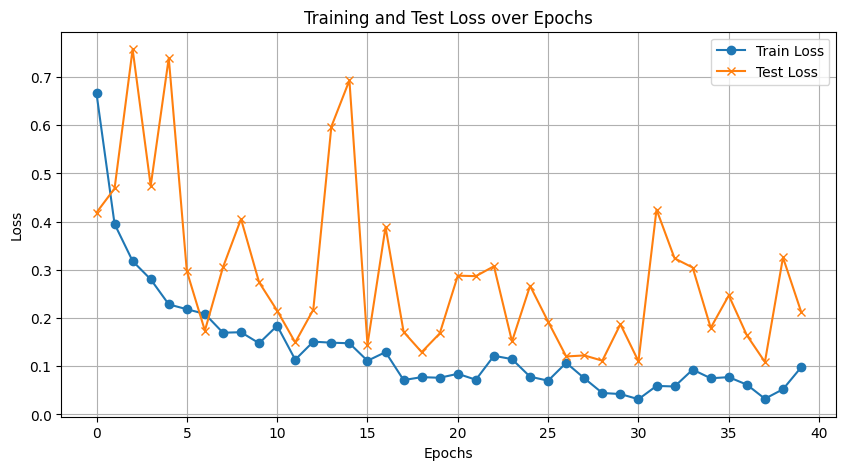

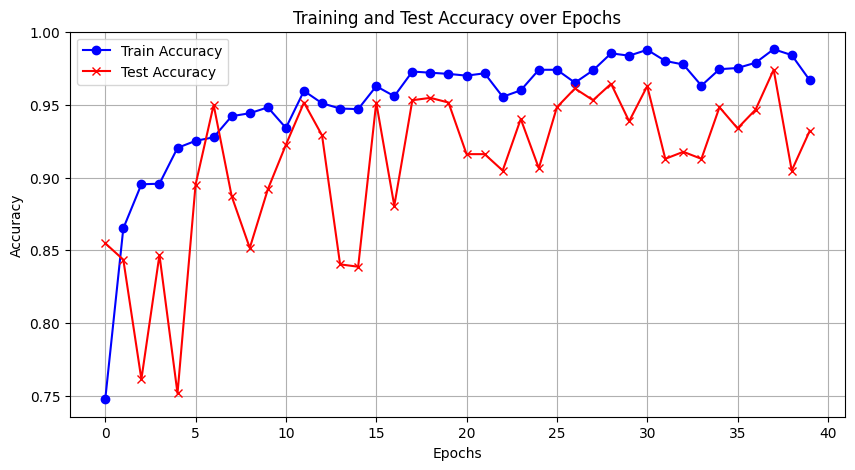

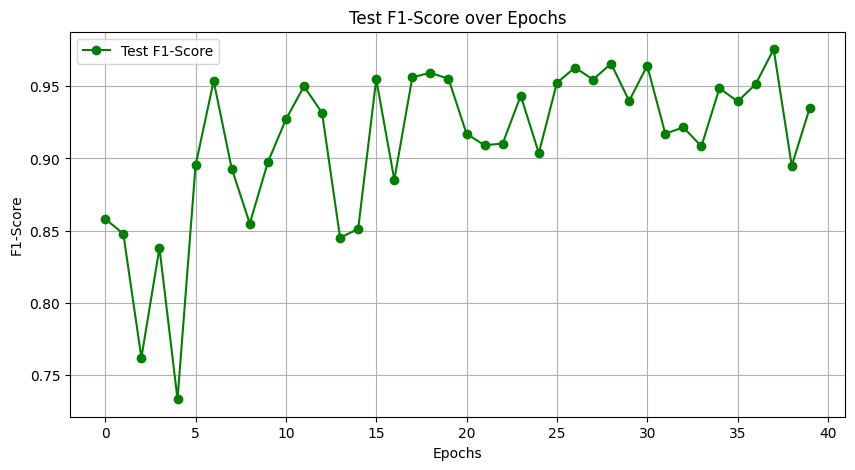

Final Test Loss: 0.2135, Final Test Accuracy: 0.9323, Final Test F1-Score: 0.9351


In [21]:
# DataLoader üzerinden veri dolaşma ve model eğitimi
num_epochs = 40
train_losses = []
test_losses = []
test_accuracies = []
train_accuracies = []
test_f1_scores = []

for epoch in range(num_epochs):
    model.train()# Modeli eğitim moduna alma
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    train_predictions = []
    train_targets = []
    for inputs, labels in train_loader: # Eğitim veri yükleyicisinde dolaşma
        inputs, labels = inputs.to(device), labels.to(device)# Veriyi cihaza gönderme
        optimizer.zero_grad()# Optimizasyon gradyanlarını sıfırlama
        outputs = model(inputs)# Model çıktıları
        loss = criterion(outputs, labels)# Loss hesaplama
        loss.backward() # Gradyanları geri yayılım ile hesaplama
        optimizer.step()# Optimizasyon adımı
        train_loss += loss.item() * inputs.size(0)# Toplam eğitim kaybına ekleme
        _, predicted_train = torch.max(outputs, 1) # Tahmin edilen sınıflar
        correct_train += (predicted_train == labels).sum().item()# Doğru tahmin sayısı
        total_train += labels.size(0)# Toplam örnek sayısı
        train_predictions.extend(predicted_train.cpu().numpy()) # Tahminleri saklama
        train_targets.extend(labels.cpu().numpy())# Gerçek etiketleri saklama
    
    train_loss = train_loss / len(train_loader.dataset)  # Ortalama eğitim kaybı
    train_losses.append(train_loss)
    
    # Train seti üzerinde modelin doğruluğunu ve f1-score'u hesaplama
    train_accuracy = correct_train / total_train  # Eğitim doğruluğu
    train_accuracies.append(train_accuracy)
    train_f1 = f1_score(train_targets, train_predictions, average='macro') # Eğitim F1 skoru
    
    # Test seti üzerinde modelin performansını test etme
    model.eval()# Modeli değerlendirme moduna alma
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    test_predictions = []
    test_targets = []
    with torch.no_grad(): # Gradyan hesaplamalarını devre dışı bırakma
        for inputs, labels in test_loader: # Test veri yükleyicisinde dolaşma
            inputs, labels = inputs.to(device), labels.to(device)  # Veriyi cihaza gönderme
            outputs = model(inputs)  # Model çıktıları
            loss = criterion(outputs, labels)   # Loss hesaplama
            test_loss += loss.item() * inputs.size(0)  # Toplam test kaybına ekleme
            _, predicted_test = torch.max(outputs, 1)  # Tahmin edilen sınıflar
            correct_test += (predicted_test == labels).sum().item()  # Doğru tahmin sayısı
            total_test += labels.size(0)
            test_predictions.extend(predicted_test.cpu().numpy())
            test_targets.extend(labels.cpu().numpy())
    
    test_loss = test_loss / len(test_loader.dataset)  # Ortalama test kaybı
    test_losses.append(test_loss)
    
    # Accuracy hesaplama
    test_accuracy = correct_test / total_test
    test_accuracies.append(test_accuracy)
    test_f1 = f1_score(test_targets, test_predictions, average='macro')
    test_f1_scores.append(test_f1)
    
      # Her epoch'ta eğitim ve test sonuçlarını yazdırma
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train F1-Score: {train_f1:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1-Score: {test_f1:.4f}")

# Training loss grafiği
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(test_losses, label='Test Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy grafiği
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy', marker='o', color='b')
plt.plot(test_accuracies, label='Test Accuracy', marker='x', color='r')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# F1-Score grafiği
plt.figure(figsize=(10, 5))
plt.plot(test_f1_scores, label='Test F1-Score', marker='o', color='g')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.title('Test F1-Score over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Son modeli kaydetme
torch.save(model.state_dict(), 'resnet_model_with_attention.pth')

# Son durumdaki loss, accuracy ve f1-score değerleri
print(f"Final Test Loss: {test_losses[-1]:.4f}, Final Test Accuracy: {test_accuracies[-1]:.4f}, Final Test F1-Score: {test_f1_scores[-1]:.4f}")